<a href="https://colab.research.google.com/github/jmk318/jmk318.github.io/blob/master/Text_Classification_via_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with RNN (LSTM)
In this session, you will ...
* Learn some basics of training a deep learning (DL) model
* 딥러닝 모델을 어떻게 학습하는지에 대한 기초지식 획득
* have deeper understanding of LSTM.
* LSTM에 대해서 알아보기
* Understand the general process of using DL models to perform text classification tasks.
* 딥러닝모델을 이용해서 텍스트 분류 태스크 진행하는 방법을 학습

Before we get started,
please go
1. make a directory named "Text Classification RNN" in your drive first.
2. **Enable GPU (or not)**:
go to --> Runtime / Change runtime type
3. If you are new to python, you can just focus on what I say and the concepts I introduce and not focus on the code for now,
you can easily find explanation for all the codes on google afterwards.

In [ ]:
# Mount this notebook with your google drive so we can access/save the files.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import nltk # 자연어처리 분야에서 자주 쓰임
# https://datascienceschool.net/03%20machine%20learning/03.01.01%20NLTK%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch # 딥러닝 필수템
# https://tutorials.pytorch.kr/beginner/introyt/introyt1_tutorial.html
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from tqdm import tqdm
!pip install -q datasets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00


## 1 - Data




### IMDb
https://www.imdb.com/title/tt15242330/


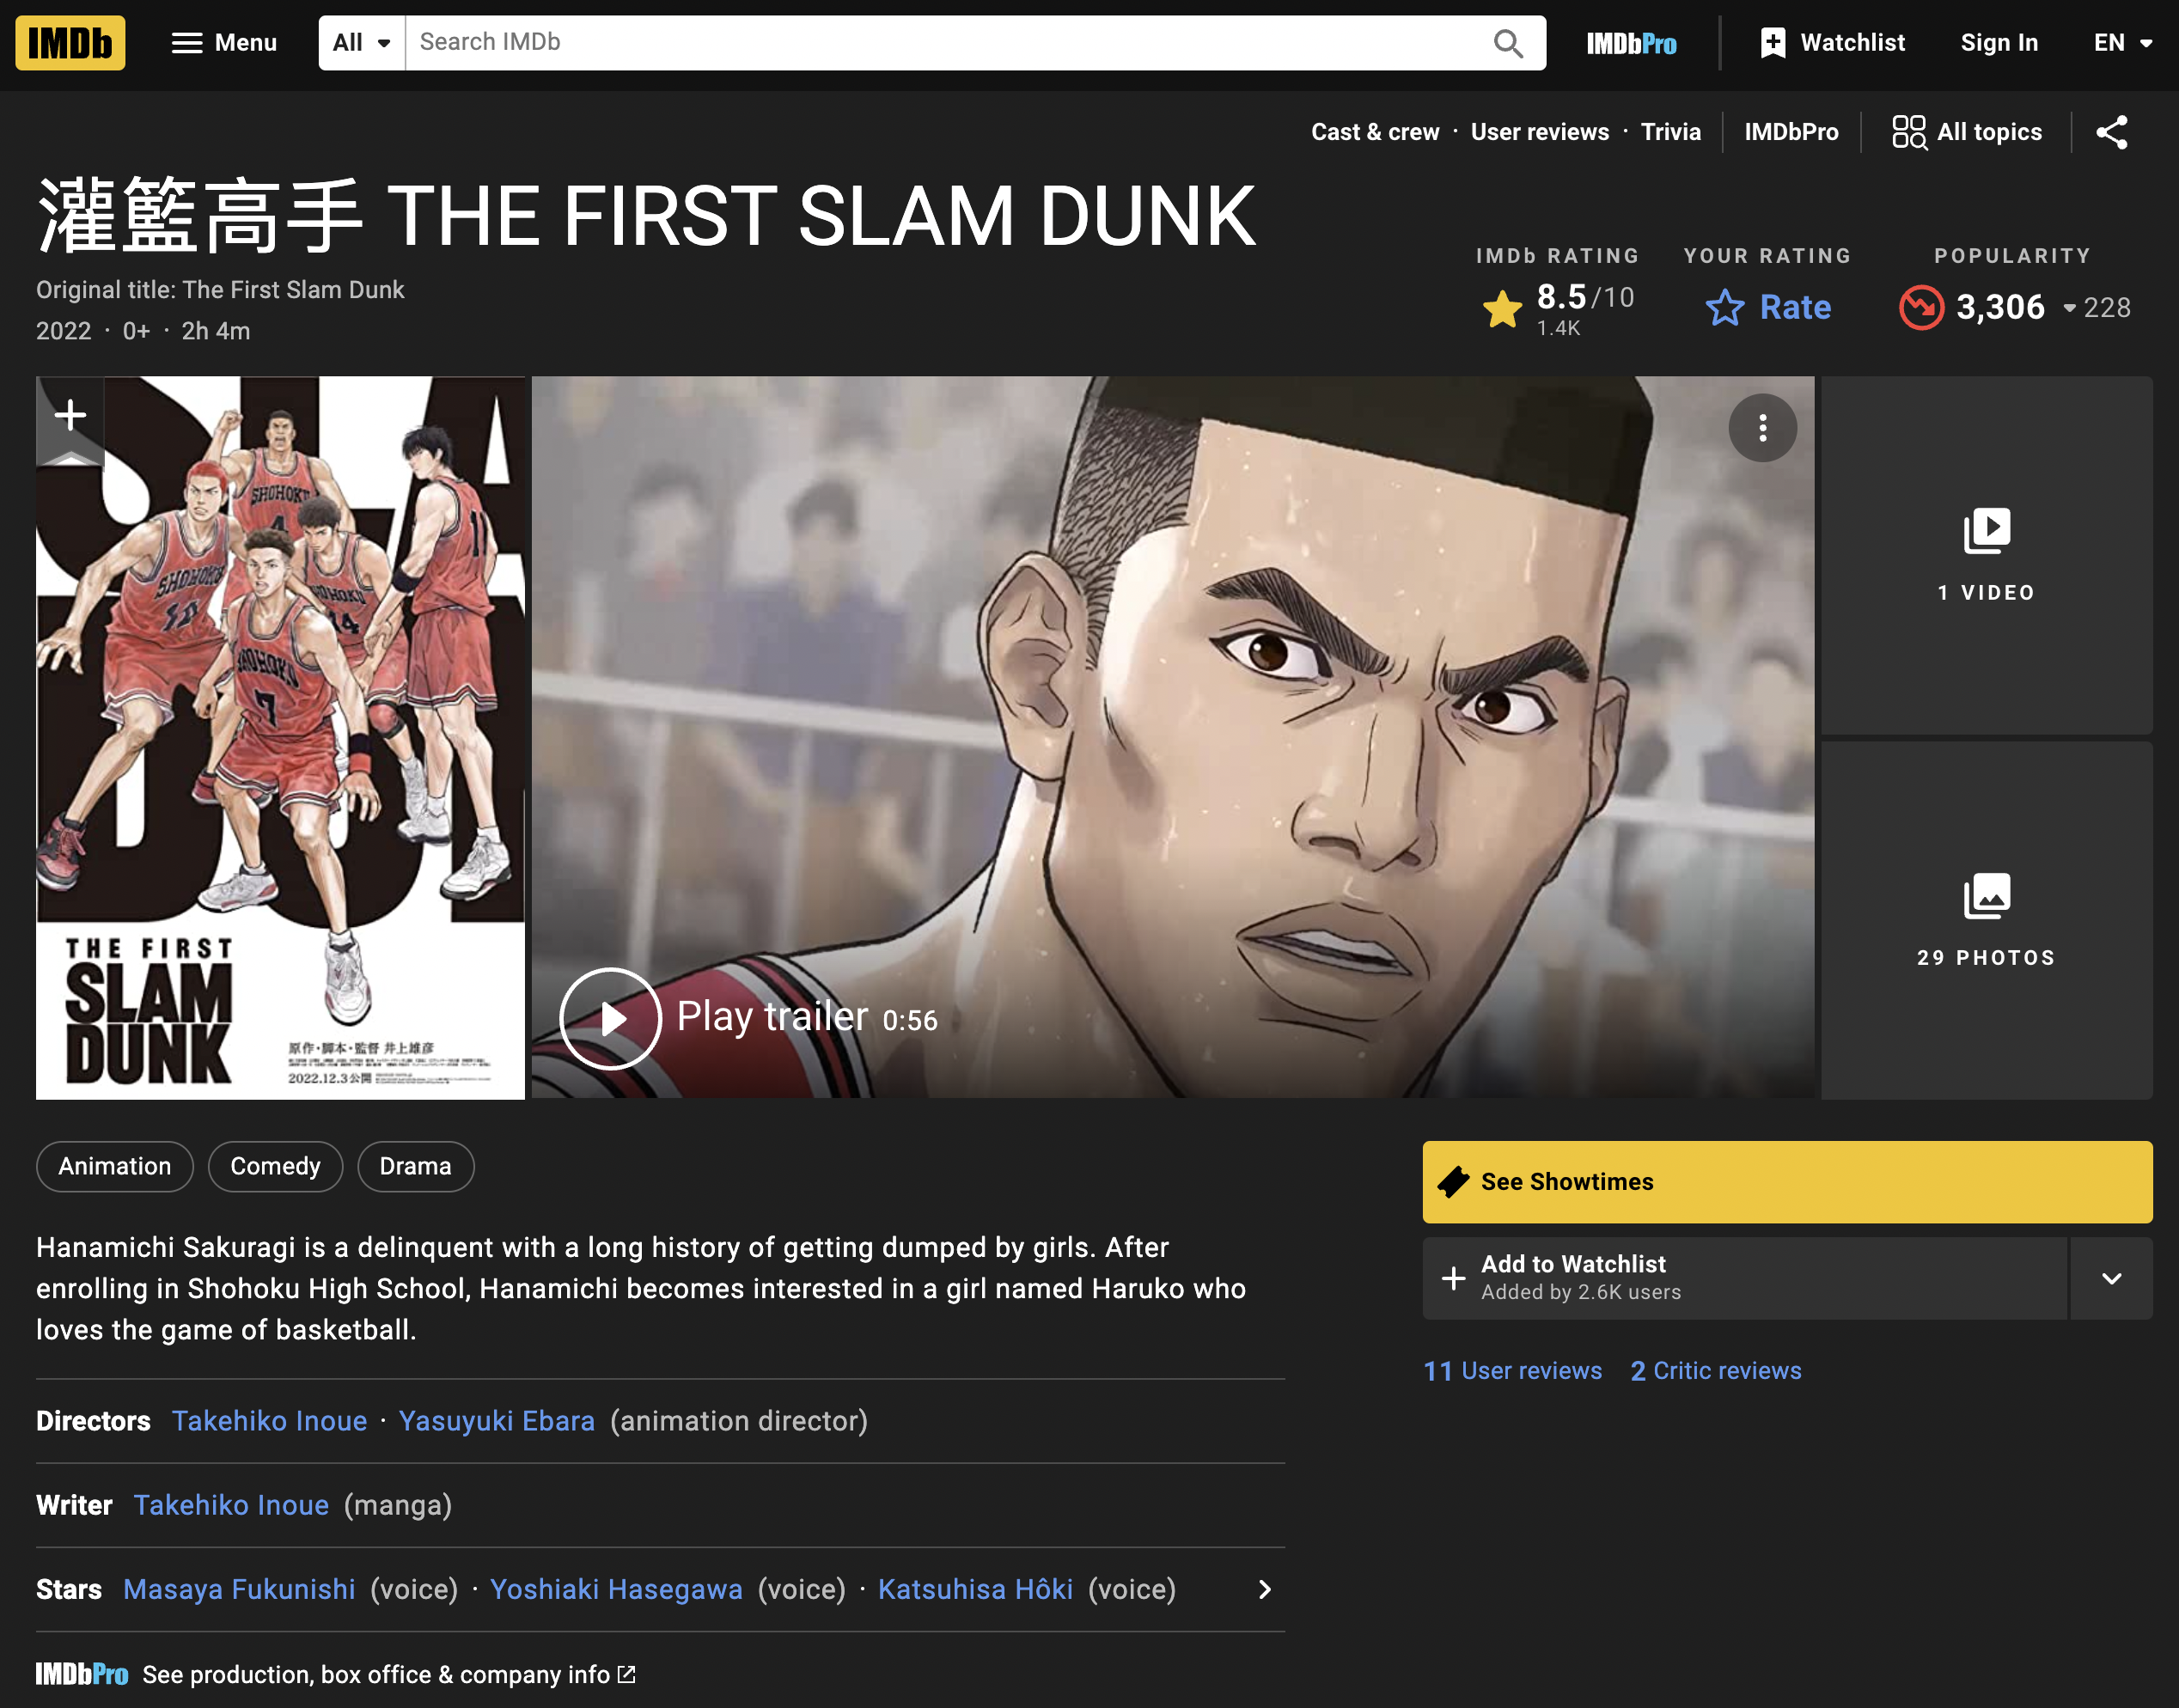

### IMDb Dataset
The IMDb dataset is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative (this is the polarity). The dataset contains of an even number of positive and negative reviews (balanced). Only highly polarizing reviews are considered. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. No more than 30 reviews are included per movie. There are 25,000 highly polar movie reviews for training, and 25,000 for testing.

http://ai.stanford.edu/~amaas/data/sentiment/

감성 분류를 연습하기 위해 자주 사용하는 영어 데이터로 영화 사이트 IMDB의 리뷰 데이터가 있습니다. 이 데이터는 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성된 데이터입니다. 스탠포드 대학교에서 2011년에 낸 논문에서 이 데이터를 소개하였으며, 당시 논문에서는 이 데이터를 훈련 데이터와 테스트 데이터를 50:50 비율로 분할하여 88.89%의 정확도를 얻었다고 소개합니다.

논문 링크 : http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf

### Getting data from huggingface
We use Hugging Face's datasets library to get the pre-processed version of the original IMDB dataset.

편리를 위해서, hugging face의 datasets library 를 통해서 데이터셋을 불러옵니다.

In [ ]:
# load the dataset and turn it into dataframe for checking
from datasets import load_dataset

dataset_train = load_dataset('imdb',split='train')
train_df=pd.DataFrame(dataset_train)

dataset_test = load_dataset('imdb',split='test')
test_df=pd.DataFrame(dataset_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_df.head(10)

text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0
5  I would put this at the top of my list of film...      0
6  Whoever wrote the screenplay for this movie ob...      0
7  When I first saw a glimpse of this movie, I qu...      0
8  Who are these "They"- the actors? the filmmake...      0
9  This is said to be a personal film for Peter B...      0

In [ ]:
# We check if the dataset properties are exactly the same as those reported in the papers
# (25,000 train, 25,000 test size, balanced). 0 = negative,  1 = positive.
# 잘 불러 왔는지 체크

data = [[train_df.label.value_counts()[0], test_df.label.value_counts()[0]],
        [train_df.label.value_counts()[1], test_df.label.value_counts()[1]]]
# Prints out the dataset sizes of train test the table form.
pd.DataFrame(data, columns=["Train", "Test"])

Train   Test
0  12500  12500
1  12500  12500

## 2 - Data pre-processing
### Combine the training and test sets 데이터 분리 다시 하기
As only training and test sets are provided, we are going to combine them and re-split them into training, validation, and test sets.

In [ ]:
all_data = pd.concat([train_df, test_df])
all_data.head()

text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0

In [ ]:
print('our combined df has a length of', all_data.shape[0])

our combined df has a length of 50000


### Cleaning

Here, we remove unicode characters, puncutation, and stopwords.

Of course, there are plenty of data cleadning methods out there, e.g., stemming.

You can google them and utilise them when you're doing your assignments :)

RE library:
https://docs.python.org/ko/3/library/re.html

보충자료:
https://wikidocs.net/21694 (한국어)



In [ ]:
def data_preprocessing(text):
    text = text.lower()
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text) # Removing Unicode Characters
    text = ''.join([c for c in text if c not in string.punctuation]) # Remove punctuation

    # Removing Stopwords
    # stop words are common words within sentences that do not add value
    # and thus can be eliminated when cleaning for NLP prior to analysis.
    # e.g., 'the', 'was'

    stop_words = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)

    return text

all_data['cleaned_text'] = all_data['text'].apply(data_preprocessing)
all_data.head()

text  label  \
0  I rented I AM CURIOUS-YELLOW from my video sto...      0   
1  "I Am Curious: Yellow" is a risible and preten...      0   
2  If only to avoid making this type of film in t...      0   
3  This film was probably inspired by Godard's Ma...      0   
4  Oh, brother...after hearing about this ridicul...      0   

                                        cleaned_text  
0  rented curious yellow video store controversy ...  
1  curious yellow risible pretentious steaming pi...  
2  avoid making type film future film interesting...  
3  film probably inspired godard masculin f minin...  
4  oh brother hearing ridiculous film umpteen yea...

## 3 - Tokenization:

### Tokenize the words

Tokenization is the process of tokenizing or splitting a string into a list of tokens.

One of the most simplest way to perform tokenization is to split the string by spaces.

https://wikidocs.net/21698
보충자료 (한국어)

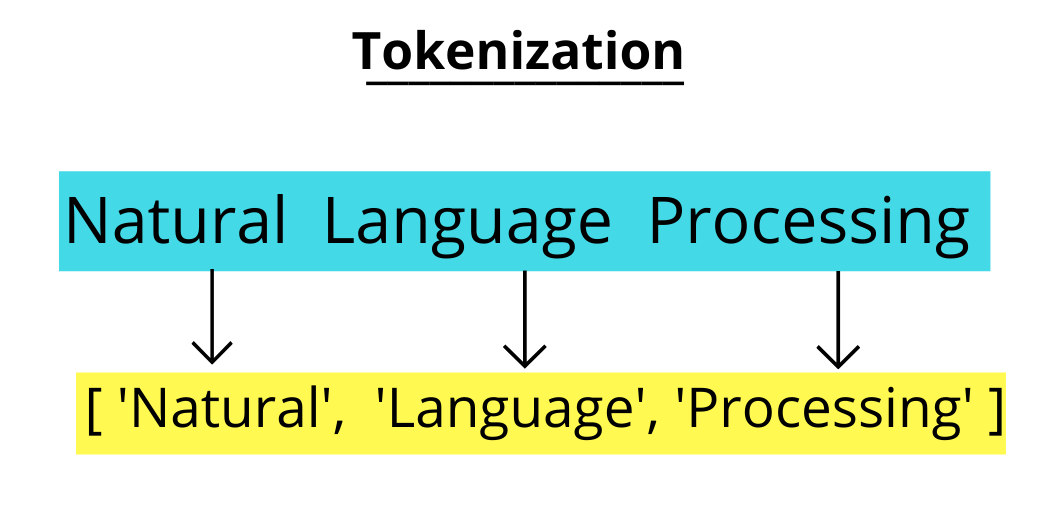




### Encode the text
We now need to transform the text into a form that can be understand by the computer, i.e., *Integer*


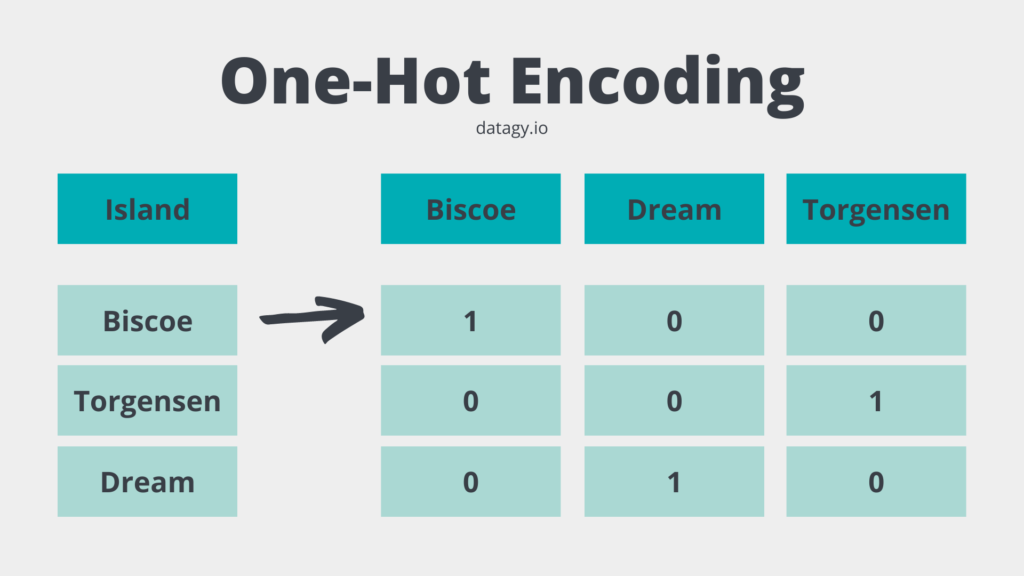



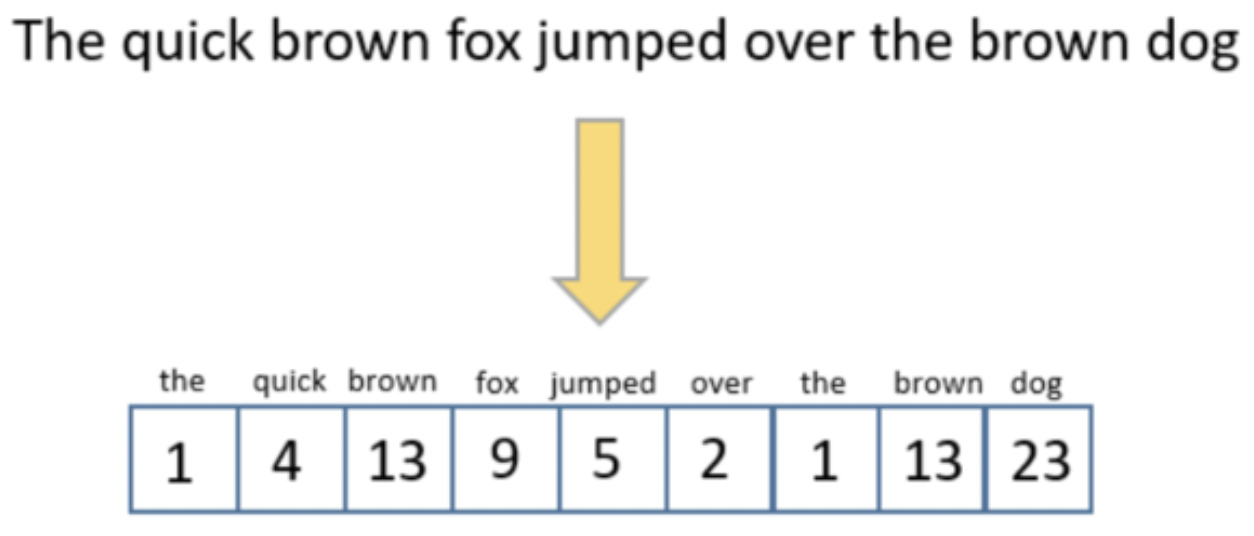



One of the most commonly used conventional method is to tokenize the words by spaces and map the words in a way that frequently occurring words have lower values.


Later in this course, other TAs will incorporate more advanced and convenient tokenization/encoding methods into your practice sessions.

###  Create Vocab-Int mapping

In [ ]:
corpus = [word for text in all_data['cleaned_text'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

In [ ]:
# set the smallest Int to 1 instead of 0
# Here, the more frequent a word is, the smaller Int it gets.

vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

text_int = []
for text in all_data['cleaned_text']:
    r = [vocab_to_int[word] for word in text.split()]
    text_int.append(r)

print(text_int[:1])
all_data['Text int'] = text_int

[[1431, 1974, 3690, 257, 938, 6219, 3479, 20, 485, 7252, 19, 426, 20, 22012, 997, 8983, 43, 631, 2174, 515, 1408, 213, 30, 1096, 2778, 11, 12, 1, 1, 35, 4014, 84, 86, 3525, 327, 1241, 639, 5628, 367, 719, 155, 37, 730, 367, 1005, 14335, 126, 312, 503, 708, 24532, 91, 632, 844, 1124, 2273, 185, 1247, 1124, 2107, 1494, 2057, 5966, 1705, 22795, 18449, 3866, 2389, 259, 327, 1489, 9373, 919, 224, 1, 1, 1025, 1974, 3690, 1376, 59, 477, 1096, 7603, 11, 259, 900, 50, 118, 8, 205, 5, 6660, 21, 3678, 25568, 211, 70, 1446, 483, 259, 900, 524, 8495, 3525, 313, 8, 11644, 2918, 4651, 1346, 6, 62, 283, 196, 1496, 259, 50, 30, 1, 1, 12911, 905, 92, 259, 478, 3, 478, 1491, 4541, 142, 1315, 17, 22, 179, 478, 7603, 2046, 705, 1974, 3690, 6, 3, 138, 1542, 1889, 3178, 16773, 4576, 1238, 3525, 313, 11, 3, 14, 35]]


## 4 - Padding and Truncating the data



### Analyze the text length

In [ ]:
text_len = [len(x) for x in text_int]
all_data['Text len'] = text_len
all_data.head()

text  label  \
0  I rented I AM CURIOUS-YELLOW from my video sto...      0   
1  "I Am Curious: Yellow" is a risible and preten...      0   
2  If only to avoid making this type of film in t...      0   
3  This film was probably inspired by Godard's Ma...      0   
4  Oh, brother...after hearing about this ridicul...      0   

                                        cleaned_text  \
0  rented curious yellow video store controversy ...   
1  curious yellow risible pretentious steaming pi...   
2  avoid making type film future film interesting...   
3  film probably inspired godard masculin f minin...   
4  oh brother hearing ridiculous film umpteen yea...   

                                            Text int  Text len  
0  [1431, 1974, 3690, 257, 938, 6219, 3479, 20, 4...       156  
1  [1974, 3690, 15766, 1975, 8184, 2465, 381, 4, ...       120  
2  [659, 126, 414, 3, 594, 3, 114, 2799, 583, 245...        55  
3  [3, 131, 1456, 7545, 62780, 1013, 62781, 4189,...        65  
4  [304, 459, 2191, 516, 3, 24534, 59, 27, 62, 73...       178

count    50000.000000
mean       123.638900
std         93.459055
min          3.000000
25%         66.000000
50%         92.000000
75%        151.000000
max       1455.000000
Name: Text len, dtype: float64


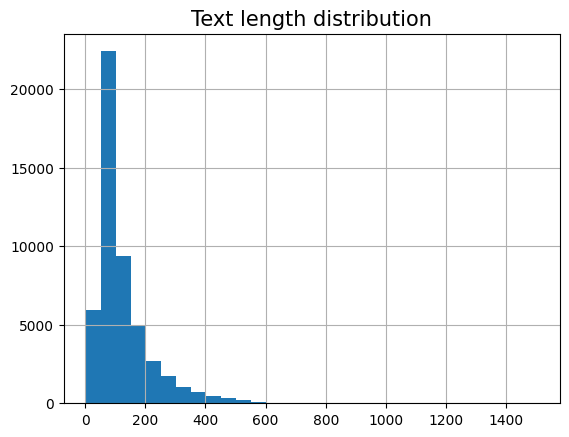

In [ ]:
print(all_data['Text len'].describe())

all_data['Text len'].hist(bins = range(min(all_data['Text len']), max(all_data['Text len']) + 50, 50))
plt.title('Text length distribution', size=15)
plt.show()

### Padding / Truncation
As in this dataset, we've got both short and long reviews (different lengths), so they can’t be converted to fixed-size tensors.
Padding and truncation are strategies for dealing with this problem.

We will pad (make longer)

or truncate (make shorter) all our reviews to a specific length.

We call this length the ``Sequence Length''.
This sequence length is same as number of time steps for LSTM layer.

: For reviews shorter than seq_length, we will pad with 0s. For reviews longer than seq_length we will truncate them to the first seq_length words.

In [ ]:
def Padding(review_int, seq_len):
    '''
    0으로 패딩
    Return features of text_int, where each text is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, text in enumerate(text_int):
        if len(text) <= seq_len:
            zeros = list(np.zeros(seq_len - len(text)))
            new = text + zeros
        else:
            new = text[: seq_len]
        features[i, :] = np.array(new)

    return features


In [ ]:
features = Padding(text_int, 200) # we set the seq_len as 200
print(features[0, :])

[ 1431  1974  3690   257   938  6219  3479    20   485  7252    19   426
    20 22012   997  8983    43   631  2174   515  1408   213    30  1096
  2778    11    12     1     1    35  4014    84    86  3525   327  1241
   639  5628   367   719   155    37   730   367  1005 14335   126   312
   503   708 24532    91   632   844  1124  2273   185  1247  1124  2107
  1494  2057  5966  1705 22795 18449  3866  2389   259   327  1489  9373
   919   224     1     1  1025  1974  3690  1376    59   477  1096  7603
    11   259   900    50   118     8   205     5  6660    21  3678 25568
   211    70  1446   483   259   900   524  8495  3525   313     8 11644
  2918  4651  1346     6    62   283   196  1496   259    50    30     1
     1 12911   905    92   259   478     3   478  1491  4541   142  1315
    17    22   179   478  7603  2046   705  1974  3690     6     3   138
  1542  1889  3178 16773  4576  1238  3525   313    11     3    14    35
     0     0     0     0     0     0     0     0   

## 5 - Dataset Split

Split the dataset into Training, Validation, and Test sets

with an 8:1:1 ratio

A simple explanation:
- Training set = 교과서 연습문제
- Validation set = 모의고사 or 퀴즈
- Testing set = 수능

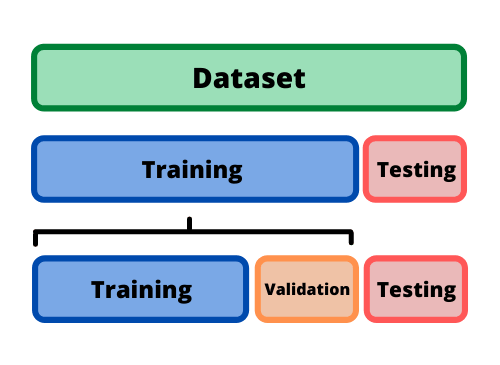

In [ ]:
X_train, X_remain, y_train, y_remain = train_test_split(features, all_data['label'].to_numpy(), test_size=0.2, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

## 6 - Dataloaders
After creating our training, test and validation split.

The next step is to create dataloaders for this data.

모델은 가중치를 한 번 업데이트하기 위해 한 개 이상의 훈련 데이터 묶음을 사용하는데, 이것을 배치라고 함.

Dataloader is what helps you feed data into the model in a form of *batches*.


In [ ]:
# trun our data into tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# set up the batch size and build dataloaders
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True) # drop_last
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
# use iter and next to obtain and see one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample labels: \n', sample_y)

Sample input size:  torch.Size([64, 200])
Sample input: 
 tensor([[15424,   118,  4499,  ...,  1194,     3,  8218],
        [ 6640,     5,    49,  ...,     0,     0,     0],
        [   24,    48,   245,  ...,     0,     0,     0],
        ...,
        [   84,  2606,  6761,  ..., 23467,  2143,   253],
        [   52,  1110,     2,  ...,     0,     0,     0],
        [23946,  9467, 39066,  ...,     0,     0,     0]])
Sample labels: 
 tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])


## 7 - The Model
### RNN with LSTM
**RNN**

you can visit https://wikidocs.net/22886 (한국어)

- **Why RNN? Because it can ``memorise''.**

  The neurons in the hidden layer can **memorise/consider** previouse inputs.

  e.g., Imaging a flight booking system.

  **Arrive** Taiwan on November 2nd. --> Taiwan = destination

  **Leave** Taiwan on November 2nd. --> Taiwan = place of departure

  - For MLP(multi-layer perceptron)-based basic feed forward neural networks,

    input = word, output = probability distribution

    therefore, same input --> same output

  However, it's different for RNN

**Long short-term memory (LSTM)**
- LSTM has 3 gates: input / output / forget gate.
  During training, it learns whether to open/close the gate

  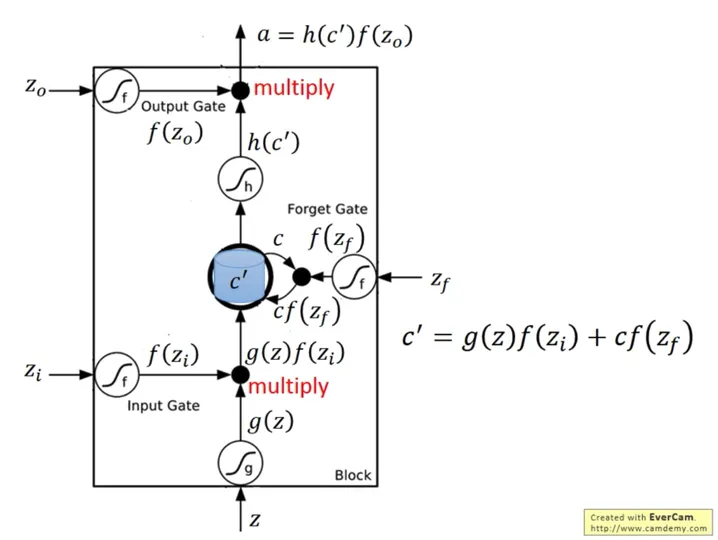

In f(Zi), f(Zf), and (Zo), the activation function f is usually the sigmoid function,

as sigmoid function return a value between 0 ~ 1，which can be used to indicate the ``how much" the gate is being opened. e.g., 1 = wide open.


## Too complicated? just think of the LSTM as an special neuron that learns to consider/forget its previous inputs!

**NN vs. LSTM**

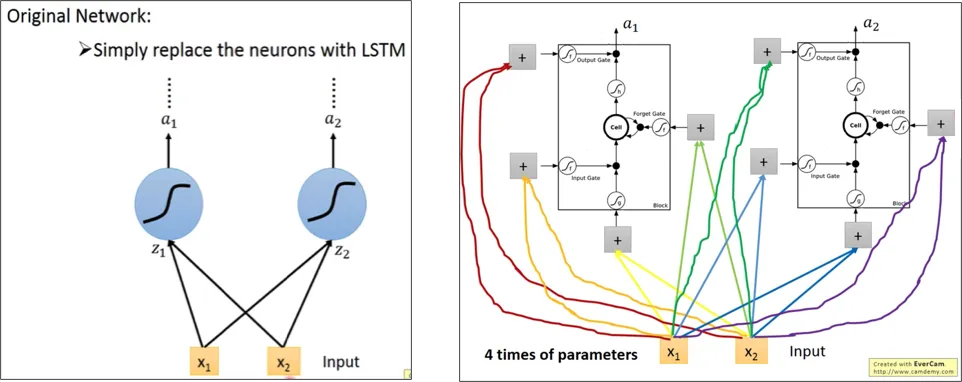

### For example

X^t = the embedding for the word ``arrive'' at time t

We multiple X^t by an matrix, turning it into a **n**-dimension tensor,

where n = the number of LSTM in this layer.

each dimension will be used as the input of each LSTM (neuron).

Repeat the same process for three more time, we can get the signal controlling the 3 gates.

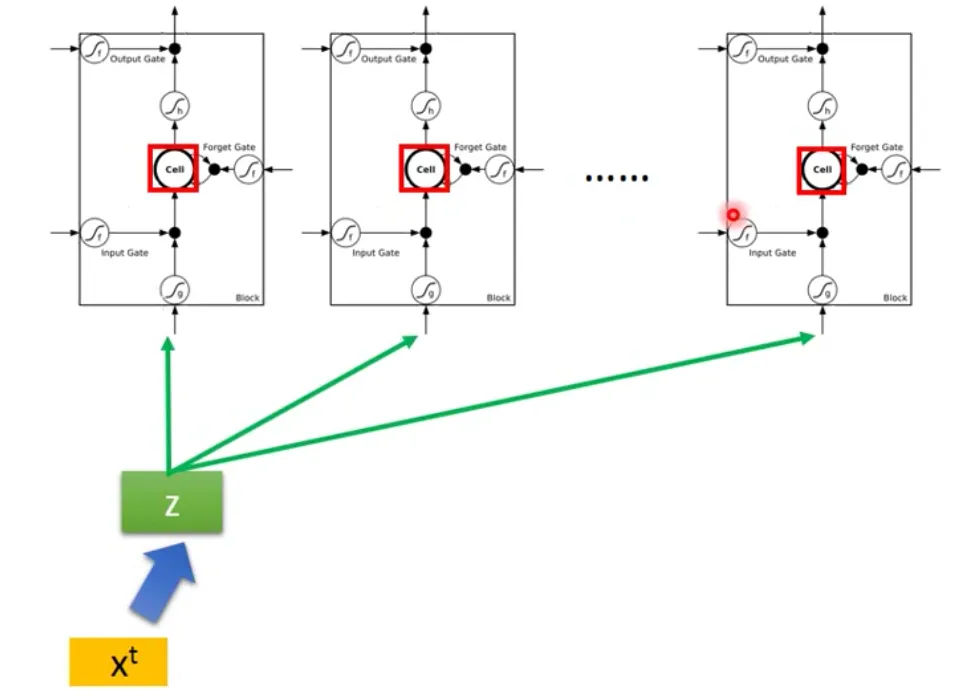

### All the 4 input signals for LSTM (you don't need to memorize it)

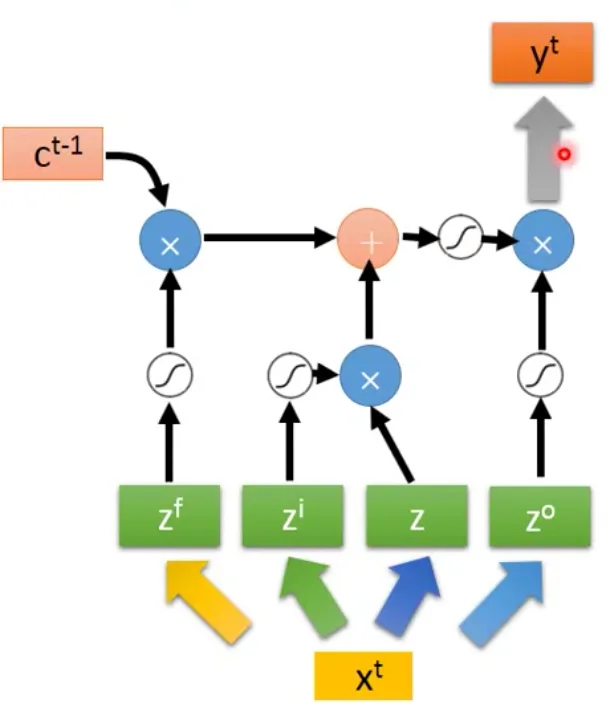

### Let's add one more time step

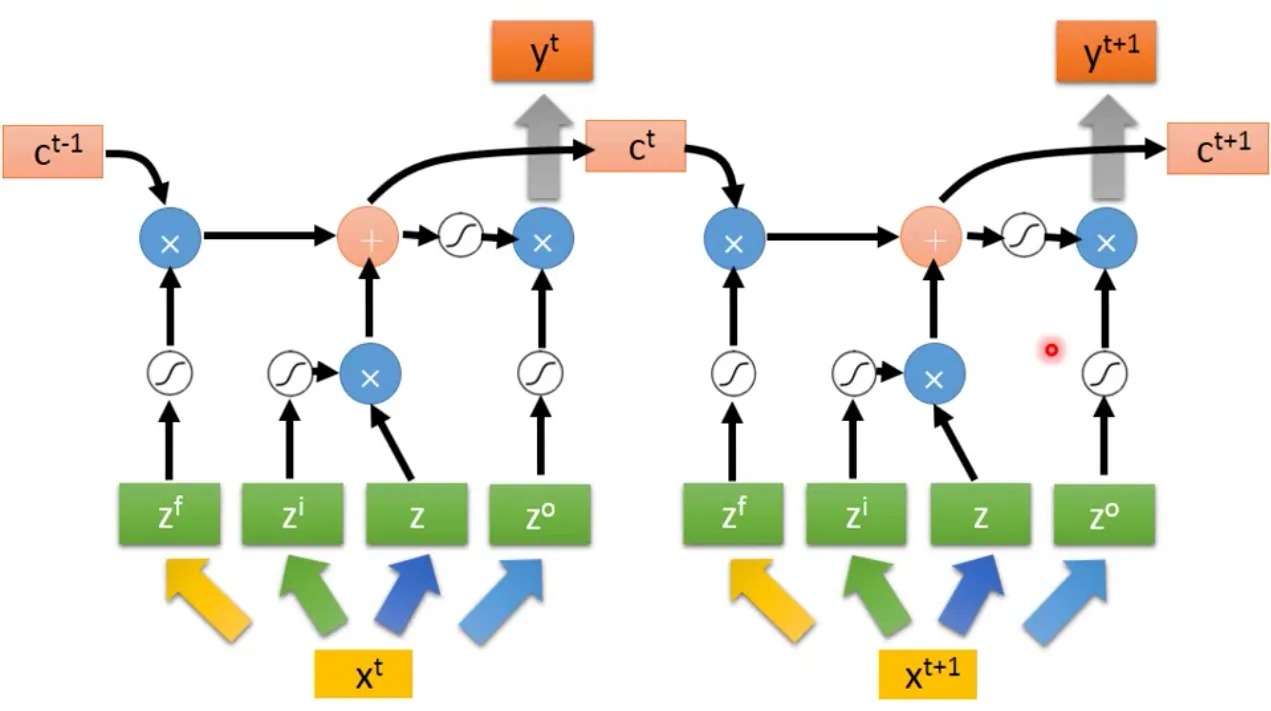

Acutually, there is more fun stuff going on in LSTM,

(e.g., [peephole](https://medium.com/nerd-for-tech/what-is-lstm-peephole-lstm-and-gru-77470d84954b))

but for the purpose of this lecture, knowing what i've mentioned is more than enoungh.

*# LSTM-related Images are obtained from professor Hung-Yi Lee of the Department of EE and the Department of CS & IE of National Taiwan University*

### Build the model

In [ ]:
is_cuda = torch.cuda.is_available()
# If GPU is available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, use CPU")

GPU is available


In [ ]:
class LSTM_Binary_Classification(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embedding and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sigmoid(out)

        # reshape to be batch size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get prediction

        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 64
hidden_dim = 256
n_layers = 2

model = LSTM_Binary_Classification(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)

print(model)

LSTM_Binary_Classification(
  (embedding): Embedding(100958, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## 8 - Training Loop
There are thousands of ways to code a training loop, you do not have to study this code, you are welcome to code in whatever way you like.

There are even libraries like Ignite (https://pytorch-ignite.ai/) and Lightning (https://www.pytorchlightning.ai/) that allow you to skip writing the training loop.

In [ ]:
lr = 0.001 # learning rate
criterion = nn.BCELoss() # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
clip = 5 # for ameliorating the exploding-gradient problem.
# https://wikidocs.net/61375 한국어
epochs = 10

In [ ]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
each_epoch_tr_loss,each_epoch_vl_loss = [],[]
each_epoch_tr_acc,each_epoch_vl_acc = [],[]
valid_loss_min = np.Inf

**Training and Validation**

Enter your path for saving the trained model before running this cell.

In [ ]:
for epoch in tqdm(range(epochs)):

    ## TRAINING ##
    train_losses = []
    train_acc = 0.0
    model.train() # do not forget this
    h = model.init_hidden(batch_size) # initialize hidden state

    for inputs, labels in train_loader:
        # Creating new variables for the hidden state, otherwise we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        inputs, labels = inputs.to(device), labels.to(device) # move to gpu or cpu

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    ## EVALUATION ##
    val_losses = []
    val_acc = 0.0
    model.eval() # do not forget this
    val_h = model.init_hidden(batch_size) # initialize hidden state

    for inputs_v, labels_v in valid_loader:

        val_h = tuple([each.data for each in val_h])

        inputs_v, labels_v = inputs_v.to(device), labels_v.to(device) # move to gpu or cpu

        output_v, val_h = model(inputs_v, val_h)
        val_loss = criterion(output_v.squeeze(), labels_v.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output_v,labels_v)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)

    each_epoch_tr_loss.append(epoch_train_loss)
    each_epoch_vl_loss.append(epoch_val_loss)
    each_epoch_tr_acc.append(epoch_train_acc)
    each_epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

    # save model if valid_loss got smaller
    if epoch_val_loss <= valid_loss_min:
        #######
        # We save the model for future-use
        torch.save(model.state_dict(), '/content/drive/MyDrive/TA_material/Text Classification RNN/state_dict.pt') # enter your path ###################
        #######
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

 20%|██        | 1/5 [00:22<01:31, 22.88s/it]

Epoch 1
train_loss : 0.6405525529384613 val_loss : 0.566954221480932
train_accuracy : 63.237500000000004 val_accuracy : 73.96000000000001
Validation loss decreased (inf --> 0.566954).  Saving model ...


 40%|████      | 2/5 [00:47<01:12, 24.11s/it]

Epoch 2
train_loss : 0.6363586526393891 val_loss : 0.599557523161937
train_accuracy : 62.982499999999995 val_accuracy : 70.16


 60%|██████    | 3/5 [01:11<00:48, 24.03s/it]

Epoch 3
train_loss : 0.6544489624023437 val_loss : 0.6734997798234988
train_accuracy : 61.222500000000004 val_accuracy : 57.06


 80%|████████  | 4/5 [01:36<00:24, 24.26s/it]

Epoch 4
train_loss : 0.650618929719925 val_loss : 0.5846326591876837
train_accuracy : 60.57 val_accuracy : 72.72


100%|██████████| 5/5 [02:02<00:00, 24.41s/it]

Epoch 5
train_loss : 0.5326714207649231 val_loss : 0.49548534628672475
train_accuracy : 75.62 val_accuracy : 78.3
Validation loss decreased (0.566954 --> 0.495485).  Saving model ...


## 9 - Test/Inference
Now we can directly use the model we've trained for inference.
As we have saved the model, you can re-use the model for inference without training again by loading the saved model. (Or models available online)

For how to load the trained model and more, you can visit
https://tutorials.pytorch.kr/beginner/saving_loading_models.html

이 사이트는 한국어로 되어 있음.

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
test_h = model.init_hidden(batch_size)

model.eval()
# iterate over test data
for inputs, labels in tqdm(test_loader):

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)

    output, test_h = model(inputs, test_h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

100%|██████████| 78/78 [00:01<00:00, 72.59it/s]

Test loss: 0.484
Test accuracy: 0.790


## 10 - Homework


### Your own project ( ~ 10/31, 23:59)

이 실습자료에 있는 코드 or 직접 짜신 코드로 다른 Text classification 데이터셋을 가지고 분류 모델 (LSTM or BiLSTM) 학습 시키고:
- 왜 이 데이터를 고랐는지 (예: 걍 영화 좋아서 ㅋ)
- 사용하시는 기법을 선택한 이유 (예시: xxxx를 하면 좋다고 들어서 ooo을 적용해봤습니다)
- 성능에 대한 분석 (예시: xxx해서 성능이 좋게 나왔다. xxx 때문에 낮게 나온 것 같다)
로 레포트 작성해주세요.

- 분량: 1 page 내 (피규어/수식 포함)
- 언어: 한국어 or 영어
- PDF로 변환 후 learnus에 제출
- 파일명 = HW_RNN_학번_이름.pdf (e.g., HW_RNN_2020145009_김코딩.pdf)

**레포트의 퀄리티가 점수에 큰 영향을 미치며, 성능만 좋다고 높은 점수를 받는 것은 아닙니다..**